In [1]:
# Imports and plotting preferences

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import textalloc as ta

sns.set_theme(style='ticks',
              palette=sns.color_palette('Dark2'),
              font='Arial',
              rc={'figure.dpi': 300,
                  'figure.figsize':(7.2,4), # 7.2 inch is full page width
                  'axes.spines.right':False,
                  'axes.spines.top':False,
                  'font.size':7,
                  'xtick.labelsize':7,
                  'ytick.labelsize':7,
                  'axes.titlesize':7,
                  'axes.labelsize':7,
                  'legend.fontsize':7,
                  'legend.title_fontsize':7})

/var/folders/5s/bxw093jd6wj429m_rr4h5yp80000gn/T/ipykernel_12126/2602945529.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# Load pairing data from RNA secondary structure files

def lookup_pair(row):
  return paired[paired[:,0]==row['nt_site']][0,1]>0

structure_files = {'Lan2022_Vero':'../data/sars2-secondary-structure/41467_2022_28603_MOESM10_ESM.txt', # for secondary analysis
                   'Lan2022_Huh7':'../data/sars2-secondary-structure/41467_2022_28603_MOESM11_ESM.txt', # higher quality than Vero
                   }

paired_dicts = {}

for key in structure_files.keys():
  filename = structure_files[key]

  with open(filename) as f:
      lines = [line.rstrip().split() for line in f]

  paired = np.array([[int(x[0]),int(x[4])] for x in lines[1:]])

  paired_dicts[key] = dict(zip(paired[:,0], paired[:,1]))

In [3]:
# Load and process fitness data

ntmut = pd.read_csv('../data/mut-fitness/ntmut_fitness_all.csv')
dms_reactivity = pd.read_excel('../data/dms-reactivity/41467_2022_28603_MOESM9_ESM.xlsx')
paired_dict = paired_dicts['Lan2022_Huh7']

def lookup_wt_seq(row):
    return row.nt_mutation[0] == sars2_sequence[row.nt_site - 1]

def get_snp(row):
  return row.nt_mutation[0]+row.nt_mutation[-1]

def get_nt(row):
  return row.nt_mutation[0]

def lookup_pair(row):
  return paired_dict[row.nt_site]>0

def get_snp_type(row):

  if row.paired:
    snp_type = 'Basepaired '
  else:
    snp_type = 'Unpaired '

  return snp_type + row.snp[0] + '→' + row.snp[1]

ntmut['snp'] = ntmut.apply(get_snp,axis=1)
ntmut['nt'] = ntmut.apply(get_nt,axis=1)

ntmut['paired'] = ntmut.apply(lookup_pair,axis=1)
ntmut['SNP type'] = ntmut.apply(get_snp_type,axis=1)

# remove second order mutations
with open('../data/wuhan-hu-1.fa') as f:
    lines = [line.rstrip() for line in f]
sars2_sequence = ''.join(lines[1:])
ntmut['wt'] = ntmut.apply(lookup_wt_seq,axis=1)
ntmut = ntmut.query('wt==True').drop('wt',axis=1)

# Look up DMS reactivity for Huh7
ntmut = pd.merge(
    ntmut,dms_reactivity[['Genome coordinate','Huh7 (filtered)']],left_on='nt_site',right_on='Genome coordinate').drop(
    'Genome coordinate',axis=1).rename(columns={'Huh7 (filtered)':'DMS reactivity'})

# Replace zero and nan with pseudominimum reactivity at minimum measured level
pseudo_DMS = ntmut['DMS reactivity'][ntmut['DMS reactivity'] > 0].min() # minimum non-zero, non-nan value used to fill zeros and nan
ntmut['DMS reactivity'] = ntmut['DMS reactivity'].replace(0, np.nan)
ntmut['DMS reactivity'] = ntmut['DMS reactivity'].fillna(pseudo_DMS)

/var/folders/5s/bxw093jd6wj429m_rr4h5yp80000gn/T/ipykernel_12126/1957346991.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels)


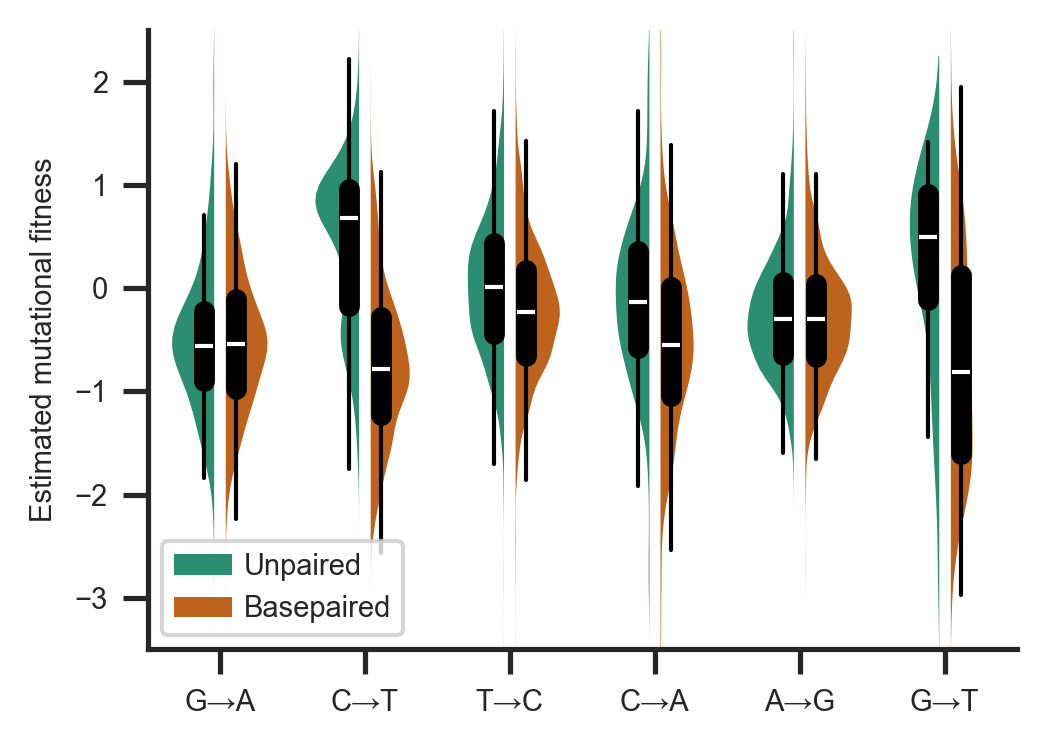

In [4]:
# Figure 1: Distributions of rates of common synonymous mutation by base pairing

def lookup_pair(row):
  return paired_dict[row.nt_site]>0

# PARAMETERS FOR ANALYSIS

limit_to = 'synonymous' # PRIMARY ANALYSIS
# limit_to = 'four_fold_degenerate' # SECONDARY ANALYSIS
# limit_to = 'noncoding' # another alternative

common_mutations = ['AG','CA','CT','GA','GT','TC']  # PRIMARY ANALYSIS

paired_dict = paired_dicts['Lan2022_Huh7'] # PRIMARY ANALYSIS
paired_dict = paired_dicts['Lan2022_Huh7'] # SECONDARY ANALYSIS

ntmut['paired'] = ntmut.apply(lookup_pair,axis=1)

plt.figure(figsize=(3.5,2.5)) # 3.5 inch for single column figure

ax = sns.violinplot(data=ntmut.query(limit_to + '==True & snp==@common_mutations'),x='snp',y='delta_fitness',hue='paired',split=True, gap=0.2,fill=True, linewidth=0,inner_kws=dict(box_width=5, whis_width=1, color="0"))
plt.ylim([-3.5,2.5])
plt.ylabel('Estimated mutational fitness')
plt.xlabel(None)

new_labels = {'False':'Unpaired','True':'Basepaired'}
handles, previous_labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=[new_labels[x] for x in previous_labels])
sns.move_legend(ax,'lower left',frameon=True,bbox_to_anchor=(0, 0),handletextpad=0.4)

labels = [item.get_text() for item in ax.get_xticklabels()]
labels = [x[0] + '→' + x[1] for x in labels]
ax.set_xticklabels(labels)

plt.tight_layout()

plt.savefig('../figures/Figure-1-fitness-and-secondary-structure.png')
plt.savefig('../figures/Figure-1-fitness-and-secondary-structure.svg')

In [5]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multitest import multipletests

# PARAMETERS

# tested_mutations = common_mutations # PRIMARY ANALYSIS
tested_mutations = ntmut.snp.unique() # SECONDARY ANALYSIS

p_values = []

# Collect all p-values from the comparisons
for snp in tested_mutations:
    df_subset = ntmut.query('snp == @snp & ' + limit_to + ' == True')
    tukey_result = pairwise_tukeyhsd(df_subset['delta_fitness'], df_subset['paired'], alpha=0.05)
    p_values.append(tukey_result.pvalues[0])

# Correct all p-values collected for multiple testing
corrected_p_values = multipletests(p_values, alpha=0.05, method='bonferroni')

# Output the corrected p-values
print("Corrected p-values for multiple testing:")

print('SNP','Change in relative fitness','p value','significant p<0.05',sep='\t')

for i in range(len(tested_mutations)):
    
    diff = ntmut.query('snp == @tested_mutations[@i] & synonymous == True')[['delta_fitness','paired']].groupby('paired').median().to_numpy()
    diff = diff[0]-diff[1]

    print(tested_mutations[i],f'%.2f'%diff[0],f'%.2E' % corrected_p_values[1][i],corrected_p_values[1][i]<0.05,sep='\t')

Corrected p-values for multiple testing:
SNP	Change in relative fitness	p value	significant p<0.05
AC	0.00	1.00E+00	False
AG	0.00	1.00E+00	False
AT	0.35	3.46E-07	True
TA	0.13	3.75E-01	False
TC	0.24	1.60E-11	True
TG	0.17	5.06E-01	False
GA	-0.02	1.00E+00	False
GC	1.36	3.91E-09	True
GT	1.30	5.48E-08	True
CA	0.41	4.22E-09	True
CG	0.79	3.29E-12	True
CT	1.46	0.00E+00	True


In [6]:
# How much does C>T median in unpaired being 1.46 and G>T 1.36 in paired correspond to frequency increase?
#   Answer: roughly 4x more frequently unpaired vs paired for both
diffs = {'C→T':1.46,'G→T':1.29}

for snp in diffs.keys():
    print(snp,f'%.2f'%np.exp(diffs[snp]))

C→T 4.31
G→T 3.63



Adjustment magnitude to normalize median mutational fitness:
SNP type	Adjustment	Fractional change in expected frequency
Basepaired C→T:	0.32	0.73
Unpaired C→T:	-1.14	3.13

Adjusted expected ration of unpaired vs basepaired synonymous C→T substitutions: 4.29

28.92% of nonsynoymous C→T sites lack DMS reactivity


<Figure size 2160x1200 with 0 Axes>

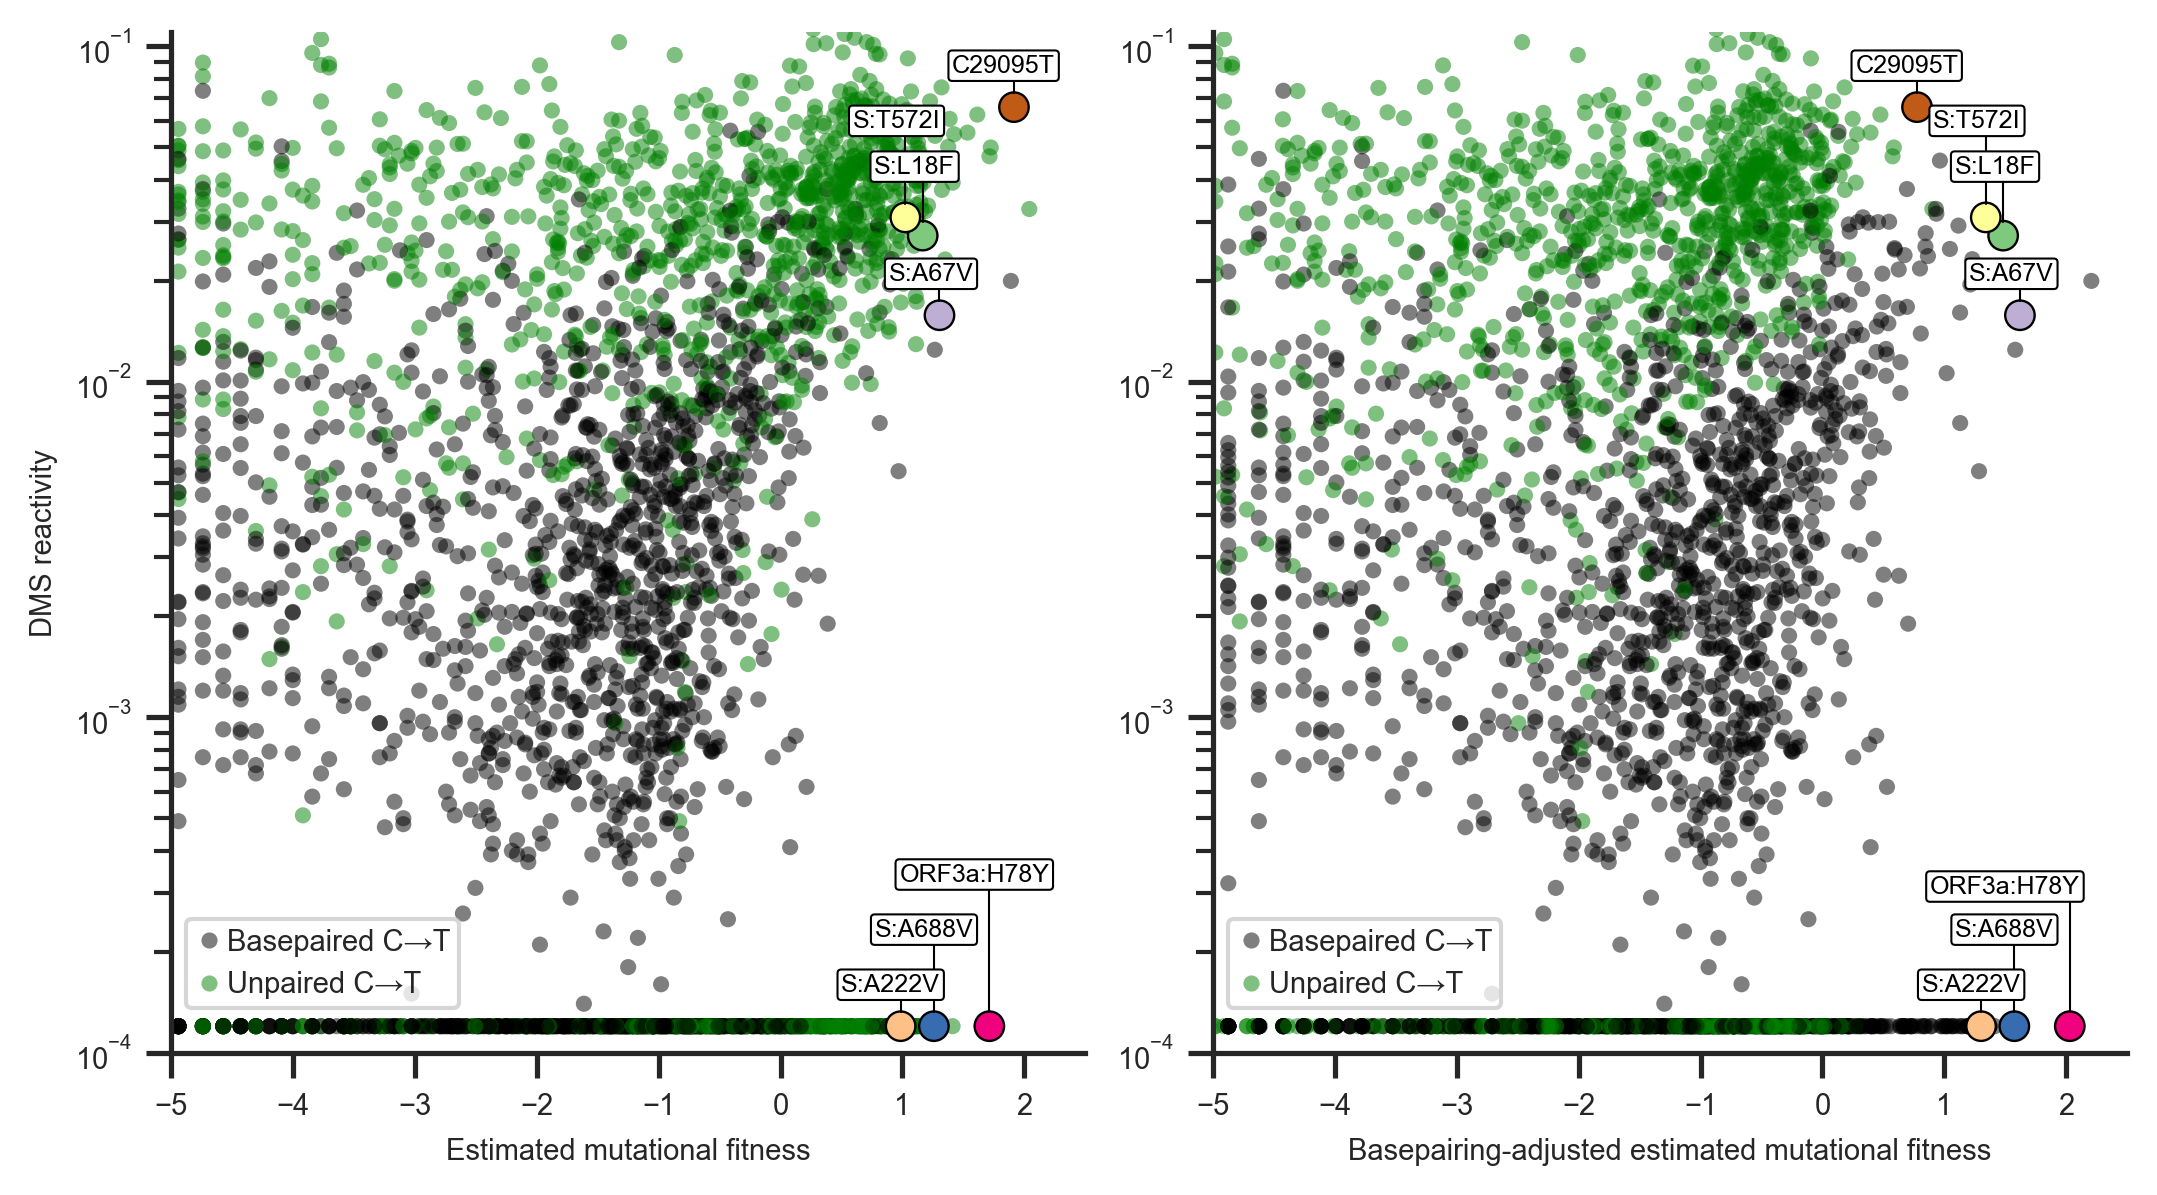

In [7]:
# Figure 2: Compare DMS reactivity to nonsynonymous mutational fitness before and after adjustment

plt.figure(figsize=(7.2,4))
xlim=[-5,2.5]
ylim=[1e-4,0.11]

# Estimate adjustment to paired and unpaired synonymous C>T required for median mutational fitnesses to match
paired_ct_fitness = ntmut.query('snp=="CT" & '+limit_to+'==True & paired==True')['delta_fitness'].to_numpy()
unpaired_ct_fitness = ntmut.query('snp=="CT" & '+limit_to+'==True & paired==False')['delta_fitness'].to_numpy()

all_ct_fitness = np.concatenate((paired_ct_fitness,unpaired_ct_fitness))

a = -(np.median(paired_ct_fitness) - np.median(all_ct_fitness))
b = -(np.median(unpaired_ct_fitness) - np.median(all_ct_fitness))

# Print result
print('\nAdjustment magnitude to normalize median mutational fitness:')
print('SNP type','Adjustment','Fractional change in expected frequency',sep='\t')
print('Basepaired C→T:',f'%.2f'%a,f'%.2f'%np.exp(-a),sep='\t')
print('Unpaired C→T:',f'%.2f'%b,f'%.2f'%np.exp(-b),sep='\t')

print('\nAdjusted expected ration of unpaired vs basepaired synonymous C→T substitutions:',f'%.2f'%np.exp(a-b))

ntmut.loc[(ntmut['snp']=='CT')&(ntmut['paired']==True),'adjusted_fitness'] = ntmut.query('paired==True & snp=="CT"').delta_fitness + a
ntmut.loc[(ntmut['snp']=='CT')&(ntmut['paired']==False),'adjusted_fitness'] = ntmut.query('paired==False & snp=="CT"').delta_fitness + b

min_dms = ntmut['DMS reactivity'].min()
n = len(ntmut.query('snp=="CT" & synonymous==False & `DMS reactivity`==@min_dms'))
N = len(ntmut.query('snp=="CT" & synonymous==False'))
print('\n' + f'%.2f'%(100.0*n/N) + '% of nonsynoymous C→T sites lack DMS reactivity')

sites_of_interest = np.array([25624,21762,23625,21614,23277,22227,29095])
site_labels = np.array(['ORF3a:H78Y','S:A67V','S:A688V','S:L18F','S:T572I','S:A222V','C29095T'])
idx = np.argsort(sites_of_interest)
sites_of_interest = list(sites_of_interest[idx])
site_labels = list(site_labels[idx])

for i in range(len(sites_of_interest)):
    ntmut.loc[(ntmut.nt_site==sites_of_interest[i])&(ntmut.snp=="CT"),"Mutation"] = site_labels[i]

fig = plt.figure(figsize=(7.2,4))

plt.subplot(1,2,1)
ax1 = sns.scatterplot(data=ntmut.query('snp==["CT"] & synonymous==False'),y='DMS reactivity',x='delta_fitness',hue='SNP type',s=15,linewidth=0,alpha=0.5, palette={'Basepaired C→T':'k', 'Unpaired C→T':'g' })
plt.xlabel('Estimated mutational fitness')
sns.scatterplot(ax=ax1,data=ntmut.query('snp==["CT"] & nt_site==@sites_of_interest'),y='DMS reactivity',x='delta_fitness',hue='Mutation',edgecolors='k',s=50,alpha=1,palette=sns.color_palette('Accent',len(sites_of_interest)),legend=False)
plt.xlim(xlim)
plt.ylim(ylim)
plt.yscale('log')
legend = ax1.legend(loc='lower left', bbox_to_anchor=(0, 0.03),markerfirst=True,handletextpad=0.1,frameon=True,borderpad=0.3,handlelength=1)

x =  ntmut.query('snp==["CT"] & nt_site==@sites_of_interest').sort_values('nt_site')[['delta_fitness','DMS reactivity']].to_numpy()
ta.allocate_text(fig,ax1,x[:,0],1.1*x[:,1],
                site_labels,
                x_scatter = 0.05+x[:,0],
                y_scatter = 1.1*x[:,1],
                textsize=6,
                y_logscale_base=10,
                avoid_label_lines_overlap=False,
                margin=0.01,
                min_distance=0.015,
                direction='north',
                nbr_candidates=1000,
                linecolor='k',
                linewidth=0.5)

plt.setp(ax1.texts,va='center',bbox=dict(facecolor='w', edgecolor='k', alpha=1,linewidth=0.5,boxstyle='round,pad=0.15'))

plt.subplot(1,2,2)
ax2 = sns.scatterplot(data=ntmut.query('snp==["CT"] & synonymous==False'),y='DMS reactivity',x='adjusted_fitness',hue='SNP type',s=15,linewidth=0,alpha=0.5, palette={'Basepaired C→T':'k', 'Unpaired C→T':'g' })
plt.xlabel('Basepairing-adjusted estimated mutational fitness')
sns.scatterplot(ax=ax2,data=ntmut.query('snp==["CT"] & nt_site==@sites_of_interest'),y='DMS reactivity',x='adjusted_fitness',edgecolors='k',s=50,alpha=1,hue='Mutation',palette=sns.color_palette('Accent',len(sites_of_interest)),legend=False)
plt.xlim(xlim)
plt.ylim(ylim)
plt.ylabel('')
plt.yscale('log')
legend = ax2.legend(loc='lower left', bbox_to_anchor=(0, 0.03),markerfirst=True,handletextpad=0.1,frameon=True,borderpad=0.3,handlelength=1)

x =  ntmut.query('snp==["CT"] & nt_site==@sites_of_interest')[['adjusted_fitness','DMS reactivity']].to_numpy()
ta.allocate_text(fig,ax2,x[:,0],1.1*x[:,1],
                site_labels,
                x_scatter = 0.05+x[:,0],
                y_scatter = 1.1*x[:,1],
                textsize=6,
                y_logscale_base=10,
                avoid_label_lines_overlap=False,
                margin=0.01,
                min_distance=0.015,
                direction='north',
                nbr_candidates=1000,
                linecolor='k',
                linewidth=0.5,
                seed=1)

plt.setp(ax2.texts,va='center',bbox=dict(facecolor='w', edgecolor='k', alpha=1,linewidth=0.5,boxstyle='round,pad=0.15'))

plt.tight_layout()

plt.savefig('../figures/Figure-2-fitness-and-secondary-structure.png')
plt.savefig('../figures/Figure-2-fitness-and-secondary-structure.svg')

In [23]:
# Is spearman correlation for synonymous and/or non-synonymous C>T fitness higher for secondary structure model or for DMS reactivity?

from scipy.stats import spearmanr
from scipy.stats import pointbiserialr

min_dms = 0 # PRIMARY ANALYSIS
# min_dms = ntmut['DMS reactivity'].min() # SECONDARY ANALYSIS eliminating zeros shows DMS reactivity is more predictive where it is measured

df_subset_syn = ntmut.query('snp == "CT" & synonymous == True & `DMS reactivity`>@min_dms')[['delta_fitness','paired','DMS reactivity','adjusted_fitness']]
df_subset_nonsyn = ntmut.query('snp == "CT" & synonymous == False & `DMS reactivity`>@min_dms')[['delta_fitness','paired','DMS reactivity','adjusted_fitness']]

# For synonymous mutations

print('\nSynonymous mutations:')
x = df_subset_syn['delta_fitness'].values

y = [not x for x in df_subset_syn['paired']]
res_paired = pointbiserialr(y,x)

y = np.log(df_subset_syn['DMS reactivity']) # log probably better for Pearson correlation here
res_dms = spearmanr(y,x)

print('Pairing point biserial correlation = ',f'%.2f'%res_paired.statistic,'+/-',f'%.2E'%res_paired.pvalue)
print('DMS reactivity Spearman correlation = ',f'%.2f'%res_dms.statistic,'+/-',f'%.2E'%res_dms.pvalue)

# For nonsynonymous mutations

print('\nNonsynonymous mutations:')
x = df_subset_nonsyn['delta_fitness'].values

y = [not x for x in df_subset_nonsyn['paired']]
res_paired = pointbiserialr(y,x)

y = np.log(df_subset_nonsyn['DMS reactivity']) # log probably better for Pearson correlation here
res_dms = spearmanr(y,x)

print('Pairing point biserial correlation = ',f'%.2f'%res_paired.statistic,'+/-',f'%.2E'%res_paired.pvalue)
print('DMS reactivity Spearman correlation = ',f'%.2f'%res_dms.statistic,'+/-',f'%.2E'%res_dms.pvalue)

# Synonymous mutations after adjustment

print('\nSynonymous mutations after adjustment:')
x = df_subset_syn['adjusted_fitness'].values

y = [not x for x in df_subset_syn['paired']]
res_paired = pointbiserialr(y,x)

y = np.log(df_subset_syn['DMS reactivity']) # log probably better for Pearson correlation here
res_dms = spearmanr(y,x)

print('Pairing point biserial correlation = ',f'%.2f'%res_paired.statistic,'+/-',f'%.2E'%res_paired.pvalue)
print('DMS reactivity Spearman correlation = ',f'%.2f'%res_dms.statistic,'+/-',f'%.2E'%res_dms.pvalue)

# For nonsynonymous mutations after adjustment

print('\nNonsynonymous mutations after adjustment:')
x = df_subset_nonsyn['adjusted_fitness'].values

y = [not x for x in df_subset_nonsyn['paired']]
res_paired = pointbiserialr(y,x)

y = np.log(df_subset_nonsyn['DMS reactivity']) # log probably better for Pearson correlation here
res_dms = spearmanr(y,x)

print('Pairing point biserial correlation = ',f'%.2f'%res_paired.statistic,'+/-',f'%.2E'%res_paired.pvalue)
print('DMS reactivity Spearman correlation = ',f'%.2f'%res_dms.statistic,'+/-',f'%.2E'%res_dms.pvalue)


Synonymous mutations:
Pairing point biserial correlation =  0.59 +/- 3.35E-152
DMS reactivity Spearman correlation =  0.45 +/- 1.96E-81

Nonsynonymous mutations:
Pairing point biserial correlation =  0.18 +/- 3.98E-27
DMS reactivity Spearman correlation =  0.13 +/- 5.52E-15

Synonymous mutations after adjustment:
Pairing point biserial correlation =  -0.17 +/- 2.01E-12
DMS reactivity Spearman correlation =  0.18 +/- 2.02E-13

Nonsynonymous mutations after adjustment:
Pairing point biserial correlation =  -0.12 +/- 3.38E-14
DMS reactivity Spearman correlation =  -0.03 +/- 1.25E-01


<Figure size 2160x1200 with 0 Axes>

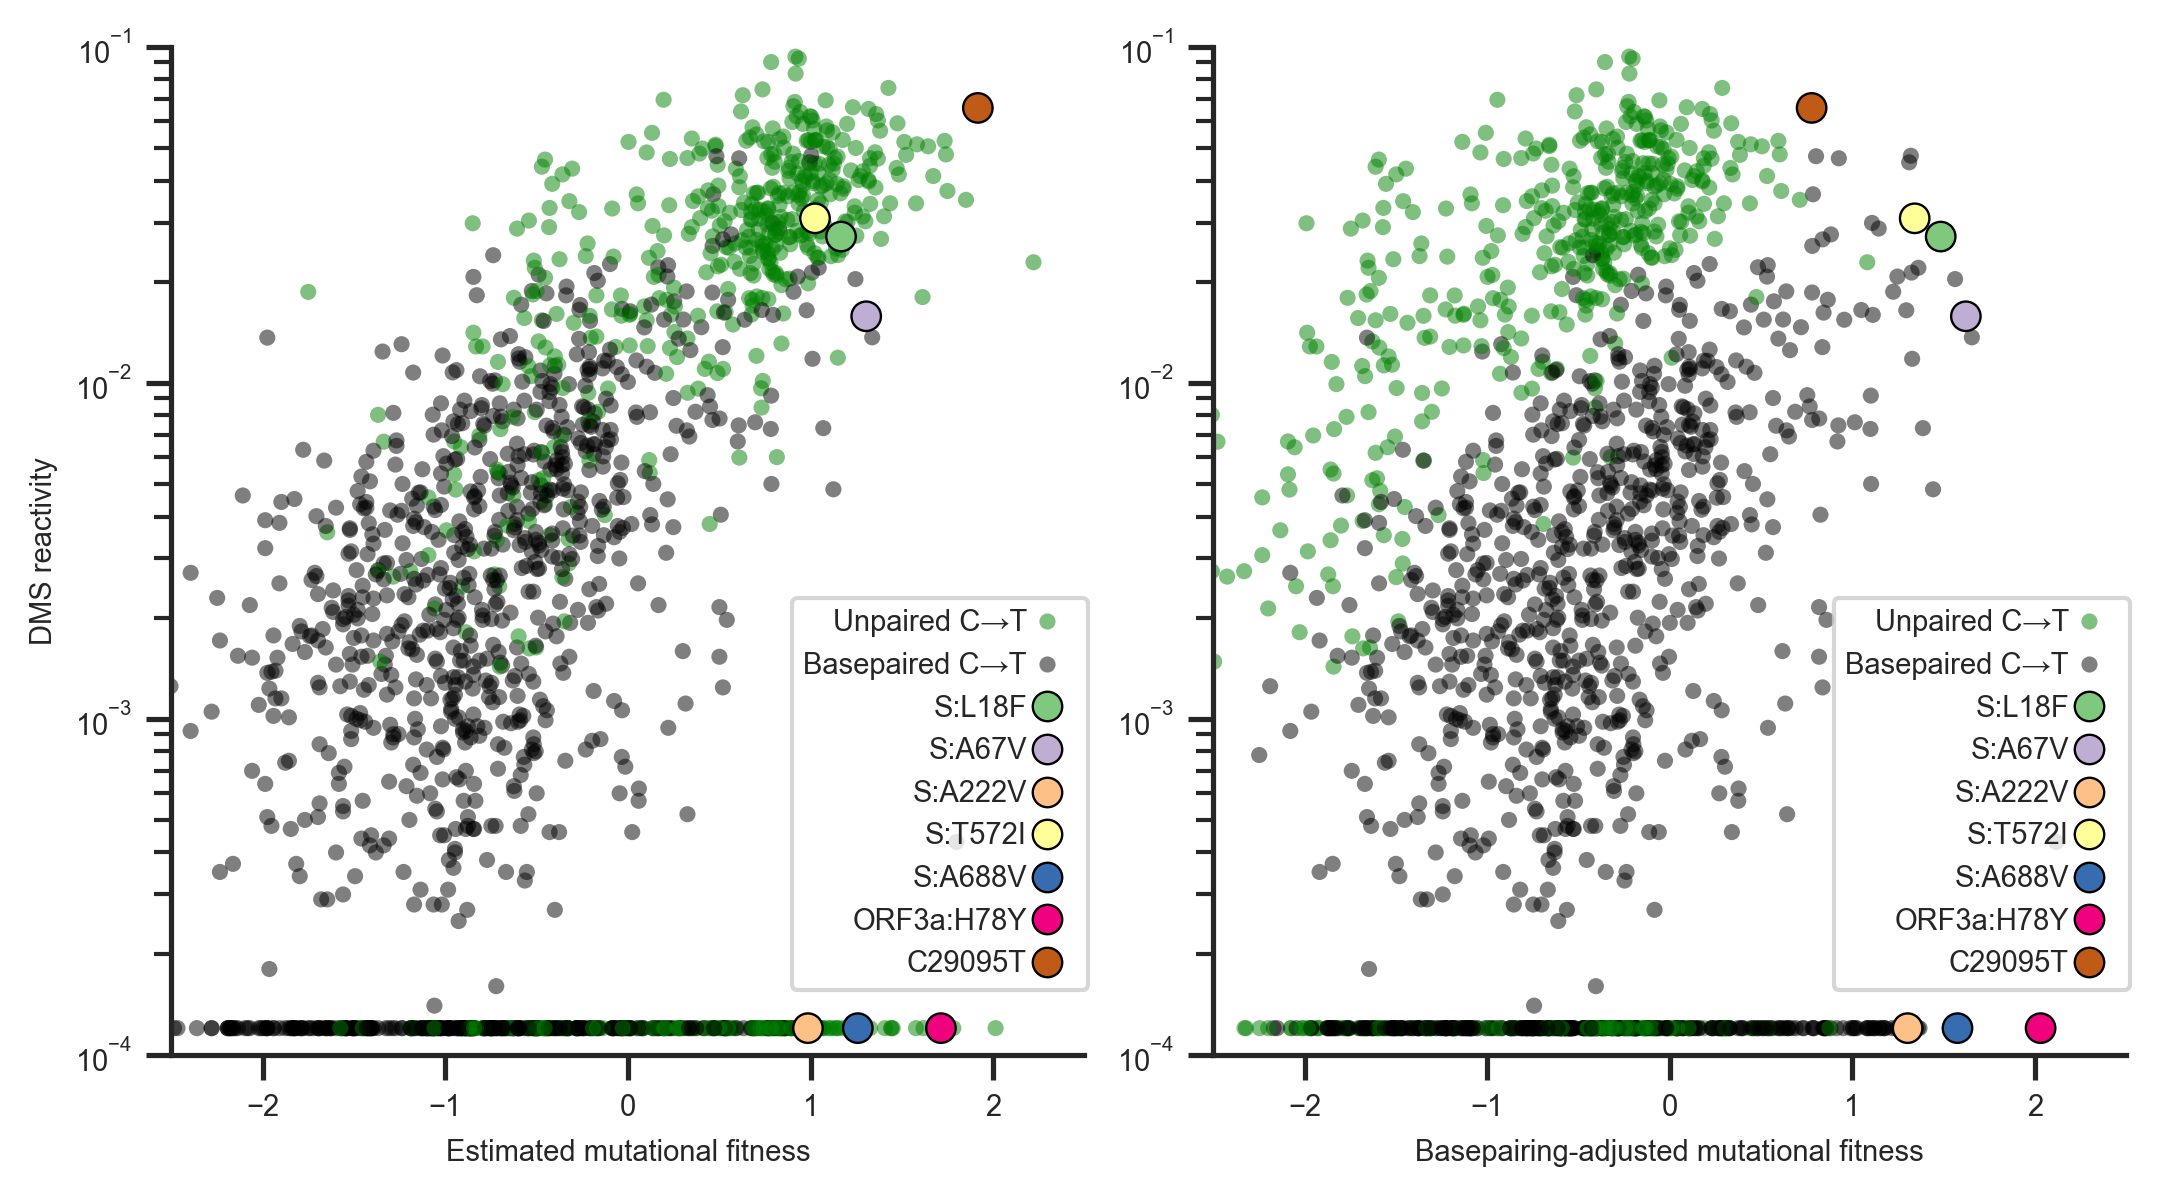

In [8]:
# Synonymous mutation equivalent of Figure 2

plt.figure(figsize=(7.2,4))
xlim=[-2.5,2.5]
ylim=[1e-4,0.1]

ntmut.loc[(ntmut['snp']=='CT')&(ntmut['paired']==True),'adjusted_fitness'] = ntmut.query('paired==True & snp=="CT"').delta_fitness + a
ntmut.loc[(ntmut['snp']=='CT')&(ntmut['paired']==False),'adjusted_fitness'] = ntmut.query('paired==False & snp=="CT"').delta_fitness + b

plt.figure(figsize=(7.2,4))

plt.subplot(1,2,1)
ax1 = sns.scatterplot(data=ntmut.query('snp==["CT"] & synonymous==True'),y='DMS reactivity',x='delta_fitness',hue='SNP type',s=15,linewidth=0,alpha=0.5, palette={'Basepaired C→T':'k', 'Unpaired C→T':'g' })
plt.xlabel('Estimated mutational fitness')
sns.scatterplot(ax=ax1,data=ntmut.query('snp==["CT"] & nt_site==@sites_of_interest'),y='DMS reactivity',x='delta_fitness',hue='Mutation',edgecolors='k',s=50,alpha=1,palette=sns.color_palette('Accent',len(sites_of_interest)))
plt.xlim(xlim)
plt.ylim(ylim)
plt.yscale('log')
legend = ax1.legend(loc='lower right', bbox_to_anchor=(1.02, 0.05),markerfirst=False,handletextpad=-0.3,frameon=True)

plt.subplot(1,2,2)
ax2 = sns.scatterplot(data=ntmut.query('snp==["CT"] & synonymous==True'),y='DMS reactivity',x='adjusted_fitness',hue='SNP type',s=15,linewidth=0,alpha=0.5, palette={'Basepaired C→T':'k', 'Unpaired C→T':'g' })
plt.xlabel('Basepairing-adjusted mutational fitness')
sns.scatterplot(ax=ax2,data=ntmut.query('snp==["CT"] & nt_site==@sites_of_interest'),y='DMS reactivity',x='adjusted_fitness',hue='Mutation',edgecolors='k',s=50,alpha=1,palette=sns.color_palette('Accent',len(sites_of_interest)))
plt.xlim(xlim)
plt.ylim(ylim)
plt.yscale('log')
legend = ax2.legend(loc='lower right', bbox_to_anchor=(1.02, 0.05),markerfirst=False,handletextpad=-0.3,frameon=True)
plt.ylabel('')

plt.tight_layout()

/Users/zach/miniconda3/envs/datascience/lib/python3.12/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/zach/miniconda3/envs/datascience/lib/python3.12/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


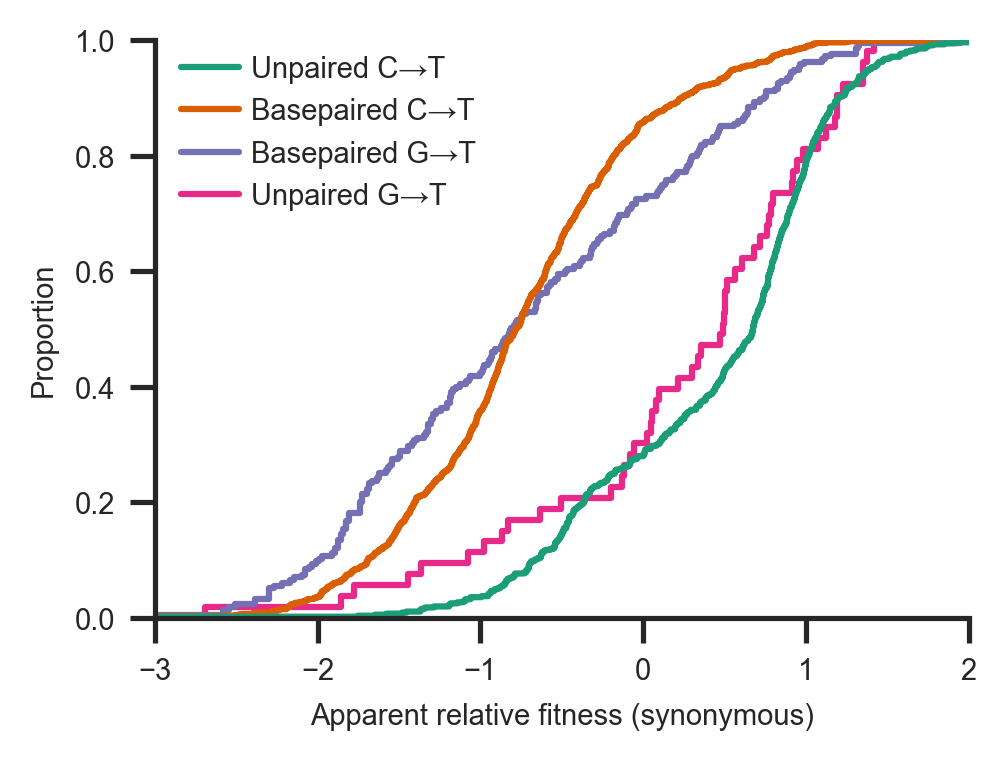

In [7]:
# Synonymous mutation CDF for alternative view of Figure 1 data

snp_types = ['Basepaired C→T', 'Unpaired C→T', 'Basepaired G→T', 'Unpaired G→T']

plt.figure(figsize=(3.5,2.5))
ax1 = sns.ecdfplot(data=ntmut.query('`SNP type`==@snp_types & synonymous==True'),x='delta_fitness',hue='SNP type')
plt.xlim([-3,2])
plt.xlabel('Apparent relative fitness (synonymous)')

ax1.legend_.set_title(None)
sns.move_legend(ax1,'upper left',frameon=False,bbox_to_anchor=(0, 1.02),handletextpad=0.4)

(0.0001, 0.1)

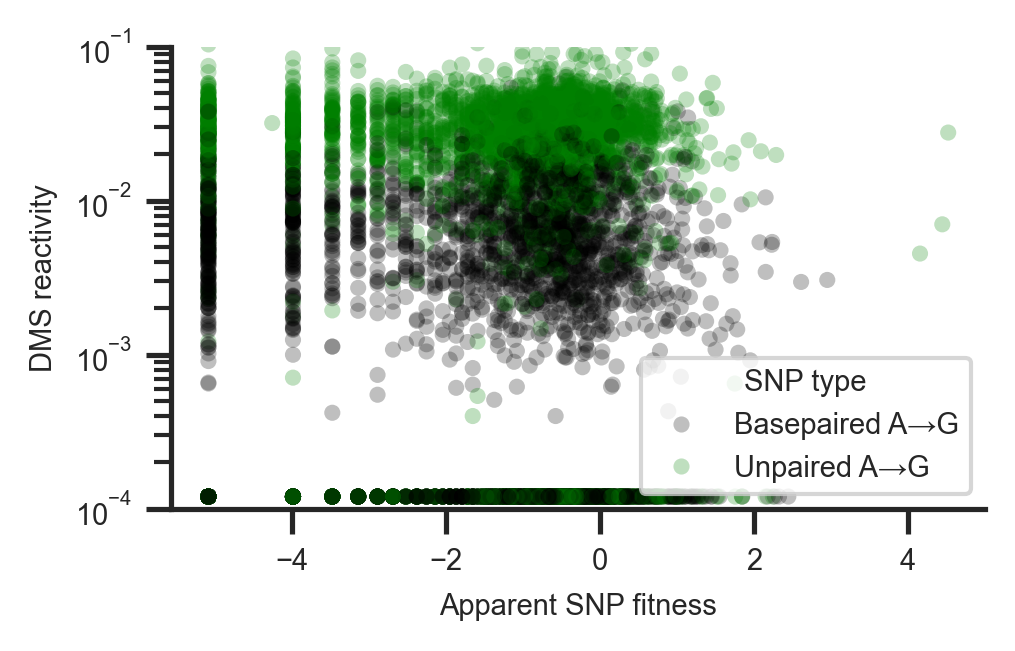

In [9]:
# compare to A>G which is frequent and covered in DMS data; no clear correlation here

plt.figure(figsize=(3.5,2))
ax1 = sns.scatterplot(data=ntmut.query('snp==["AG"] & synonymous==False'),y='DMS reactivity',x='delta_fitness',hue='SNP type',s=15,linewidth=0,alpha=0.25, palette={'Basepaired A→G':'k', 'Unpaired A→G':'g' })
plt.xlabel('Apparent SNP fitness')
plt.yscale('log')
plt.ylim([1e-4,0.1])

/var/folders/5s/bxw093jd6wj429m_rr4h5yp80000gn/T/ipykernel_12126/383896443.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels)


(-4.0, 3.0)

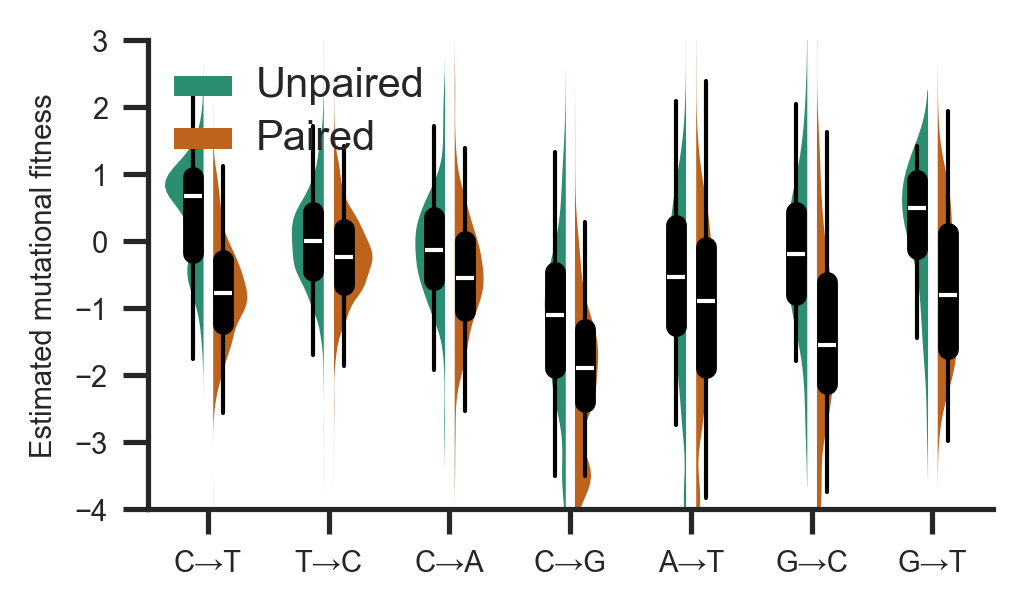

In [10]:
# Plot only significant violin plots regardless of SNP frequency

def lookup_pair(row):
  return paired_dict[row.nt_site]>0

common_mutations = np.array(tested_mutations)[corrected_p_values[1]<0.05].tolist()

paired_dict = paired_dicts['Lan2022_Huh7']
ntmut['paired'] = ntmut.apply(lookup_pair,axis=1)

plt.figure(figsize=(3.5,2))

ax = sns.violinplot(data=ntmut.query('synonymous==True & snp==@common_mutations'),x='snp',y='delta_fitness',hue='paired',split=True, gap=0.2,fill=True, linewidth=0,inner_kws=dict(box_width=5, whis_width=1, color="0"))
plt.ylabel('Estimated mutational fitness')
plt.xlabel(None)

new_labels = {'False':'Unpaired','True':'Paired'}
handles, previous_labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=[new_labels[x] for x in previous_labels], loc='upper left',frameon=False)

labels = [item.get_text() for item in ax.get_xticklabels()]
labels = [x[0] + '→' + x[1] for x in labels]
ax.set_xticklabels(labels)

plt.setp(ax.get_legend().get_texts(), fontsize='10')
plt.tight_layout()

plt.ylim([-4,3])

In [11]:
# top rank paired, non-synonymous CT
ntmut.query('synonymous==False & snp==["CT"] & paired==True')[['nt_mutation','delta_fitness','DMS reactivity']].sort_values('delta_fitness',ascending=False)[0:15]

,nt_mutation,delta_fitness,DMS reactivity
8465,C3096T,1.89090,0.01997
75776,C25624T,1.71410,0.00012
64241,C21762T,1.30480,0.01578
36449,C12459T,1.26610,0.01245
69803,C23625T,1.25890,0.00012
75743,C25613T,1.21990,0.00012
63797,C21614T,1.16700,0.02725
59678,C20233T,1.10010,0.00012
86939,C29358T,1.09270,0.02950
54131,C18377T,1.05590,0.00012


In [12]:
# top rank unpaired, synonymous CT
ntmut.query('synonymous==False & snp==["CT"] & paired==False')[['nt_mutation','delta_fitness','DMS reactivity']].sort_values('delta_fitness',ascending=False)[0:15]

,nt_mutation,delta_fitness,DMS reactivity
34322,C11750T,2.0421,0.03271
81329,C27476T,1.7257,0.04990
83165,C28093T,1.7152,0.04696
83147,C28087T,1.6154,0.06253
84908,C28677T,1.5343,0.05526
81632,C27577T,1.4245,0.05465
86624,C29253T,1.4130,0.03920
76652,C25916T,1.4123,0.00012
37439,C12789T,1.3880,0.06072
209,C335T,1.3761,0.05012


In [13]:
# frequency of pairing for common SNPs

snps = ['AG','CT','GT','TC']

for snp in snps:
  p = np.sum(ntmut.query('snp==@snp').paired == True)
  u = np.sum(ntmut.query('snp==@snp').paired == False)
  frac = p / (u+p)
  print(snp,f'%.2f' % frac + '%')

AG 0.46%
CT 0.60%
GT 0.73%
TC 0.53%


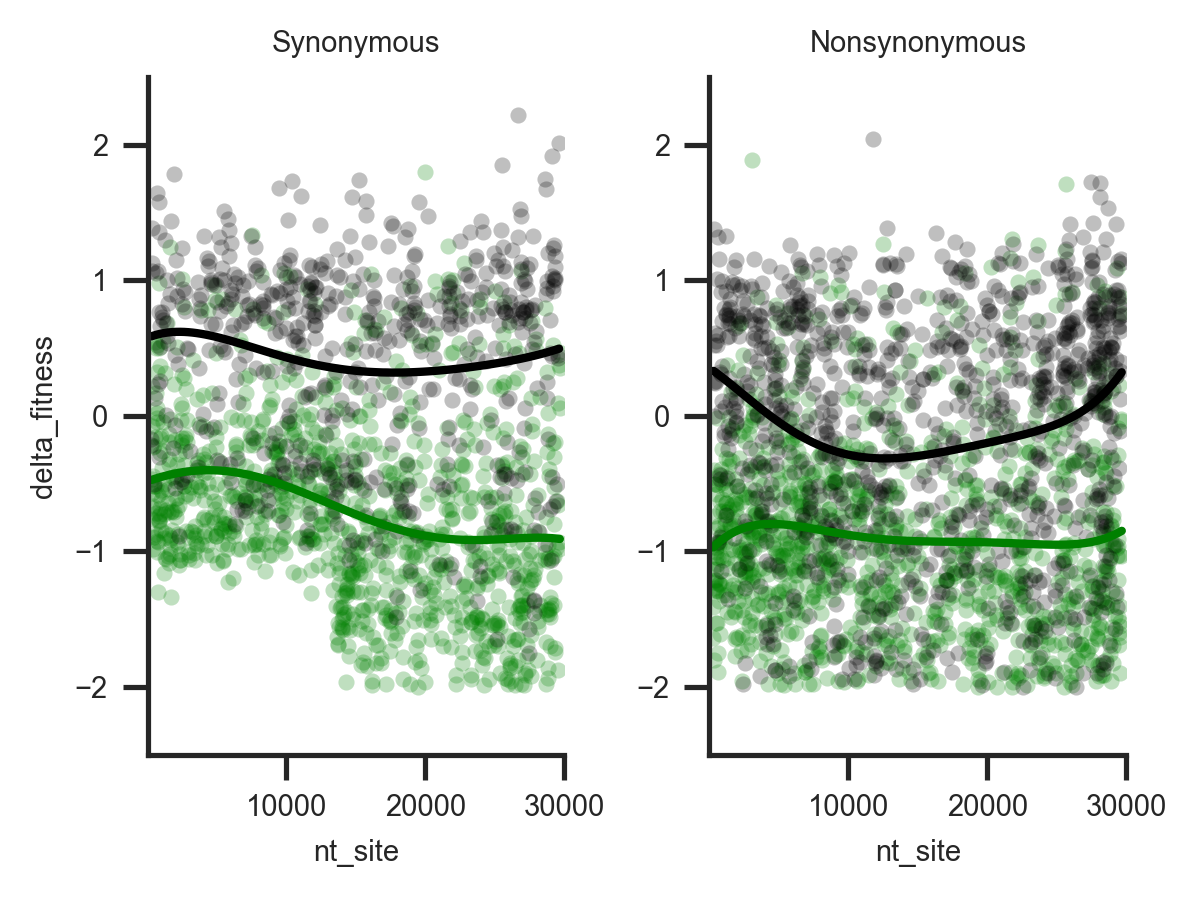

In [14]:
#  Example whether pair:unpaired difference is constant along genome; arbitrary polynomial regression for visualization

min_delta_fitness_to_consider = -2.0 # otherwise very, very low mutational fitness for some NS adds too much noise
ylim = [-2.5,2.5]
# plot along the chromosome synonymous C>T
plt.figure(figsize=(4,3))
plt.subplot(1,2,1)
ax1 = sns.regplot(data=ntmut.query('snp=="CT" & synonymous==True & paired==True & delta_fitness>@min_delta_fitness_to_consider'),x='nt_site',y='delta_fitness',order=5,ci=None,scatter_kws=dict(s=15,linewidths=0,alpha=0.25,color='g'),line_kws=dict(color="g",linewidth=2))
sns.regplot(ax=ax1,data=ntmut.query('snp=="CT" & synonymous==True & paired==False & delta_fitness>@min_delta_fitness_to_consider'),x='nt_site',y='delta_fitness',order=5,ci=None,scatter_kws=dict(s=15,linewidths=0,alpha=0.25,color='k'),line_kws=dict(color="k",linewidth=2))
plt.ylim(ylim)
plt.xlim([1,30000])
plt.title('Synonymous')

# For non-synonymous mutations this is not so great because of so much large and variable negative fitness; filtering to things not super low helps
plt.subplot(1,2,2)
ax2 = sns.regplot(data=ntmut.query('snp=="CT" & synonymous==False & paired==True & delta_fitness>@min_delta_fitness_to_consider'),x='nt_site',y='delta_fitness',order=5,ci=None,scatter_kws=dict(s=15,linewidths=0,alpha=0.25,color='g'),line_kws=dict(color="g",linewidth=2))
sns.regplot(ax=ax2,data=ntmut.query('snp=="CT" & synonymous==False & paired==False & delta_fitness>@min_delta_fitness_to_consider'),x='nt_site',y='delta_fitness',order=5,ci=None,scatter_kws=dict(s=15,linewidths=0,alpha=0.25,color='k'),line_kws=dict(color="k",linewidth=2))
plt.ylabel('')
plt.ylim(ylim)
plt.xlim([1,30000])
plt.title('Nonsynonymous')

plt.tight_layout()


Expected C29095T occurances: 630.04
Observed C29095T: 4277
C29095T occurs 6.79 times as frequently as expected for a C→T mutation
C29095T ranks 4 out of 5372 C→T mutations


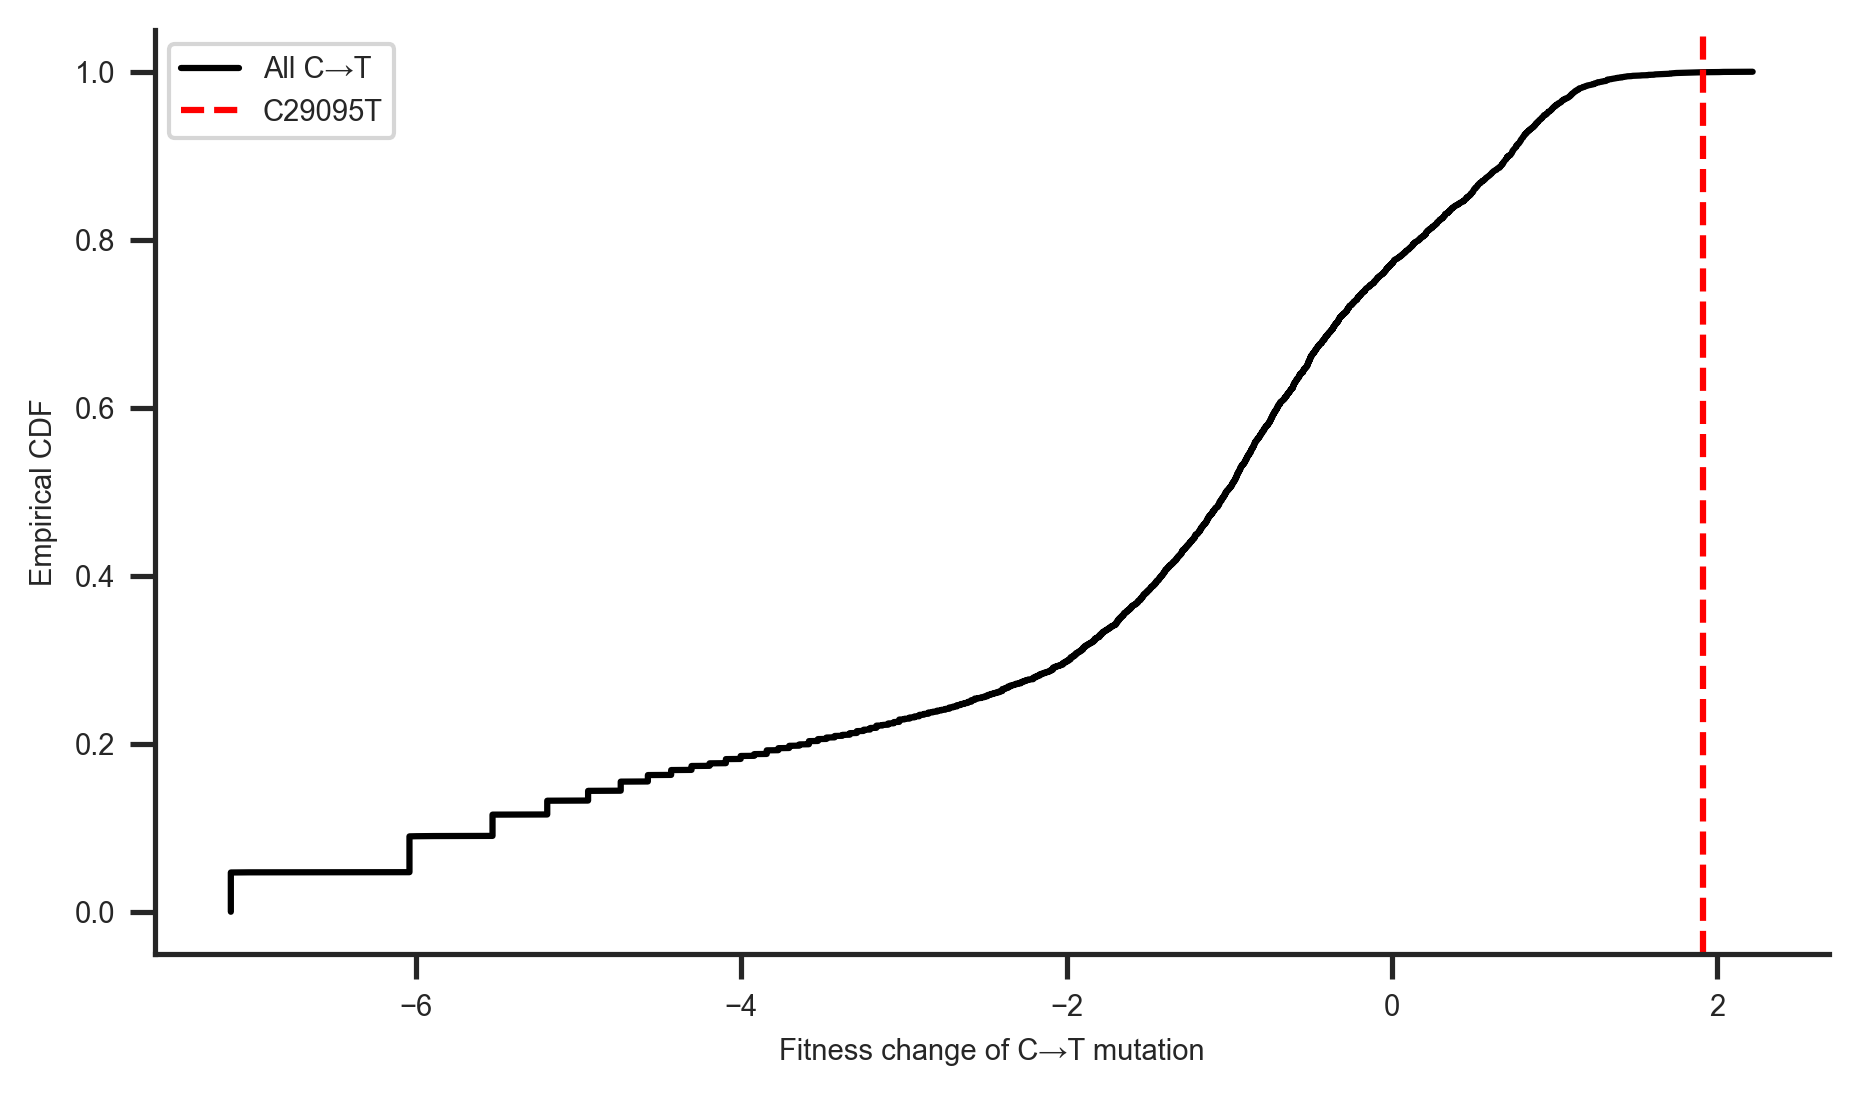

In [16]:
# Initial C29095T comparison to other CT; figure not used in manuscript but represents initial investigation

nt_fitness = pd.read_csv('../data/mut-fitness/nt_fitness.csv')
c_sites = nt_fitness.query('nt=="C" & fitness==0').nt_site.to_list()
c_t_sites = nt_fitness.query('nt_site==@c_sites & nt=="T"')

sites_of_interest = [29095]
fitnesses = c_t_sites.query('nt_site==@sites_of_interest').fitness.to_numpy()

all_fitnesses_ct = np.sort(c_t_sites.fitness.to_numpy())
p_ct = 1. * np.arange(len(all_fitnesses_ct)) / (len(all_fitnesses_ct) - 1)

plt.plot(all_fitnesses_ct, p_ct, 'k-',label='All C→T')

for i in range(len(sites_of_interest)):
  plt.axvline(x=fitnesses[i], color='r', linestyle='--', label='C'+str(sites_of_interest[i])+'T')

plt.xlabel('Fitness change of C→T mutation')
plt.ylabel('Empirical CDF')
plt.legend()

rank_29095 = len(c_t_sites.query('fitness>=@fitnesses[0]'))

# calculate expected vs actual
fit_29095 = c_t_sites.query('nt_site==29095').fitness.to_numpy() # fitness
exp_29095 = c_t_sites.query('nt_site==29095').expected_count.to_numpy() # expected counts
act_29095 = np.exp(fit_29095) * (exp_29095 - 0.5) - 0.5 # actual counts

print('\nExpected C29095T occurances:',exp_29095[0])
print('Observed C29095T:',int(act_29095[0]))
print('C29095T occurs',f'%.2f' %(act_29095[0]/exp_29095[0]),'times as frequently as expected for a C→T mutation')
print('C29095T ranks',rank_29095,'out of',len(all_fitnesses_ct),'C→T mutations')